In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Lab 3

Today the lab is a bit more sparse on explanation, but I think it would be nice to drill down into gaussian mixture modeling. 

Let's start with the old faithful data you used in your homework:

In [2]:
from urllib2 import urlopen
path = 'faithful.txt'
remote = urlopen('https://raw.githubusercontent.com/aidiary/PRML/master/ch9/faithful.txt')
with open('faithful.txt', 'w') as f:
    f.write(remote.read())

<IPython.core.display.Javascript object>


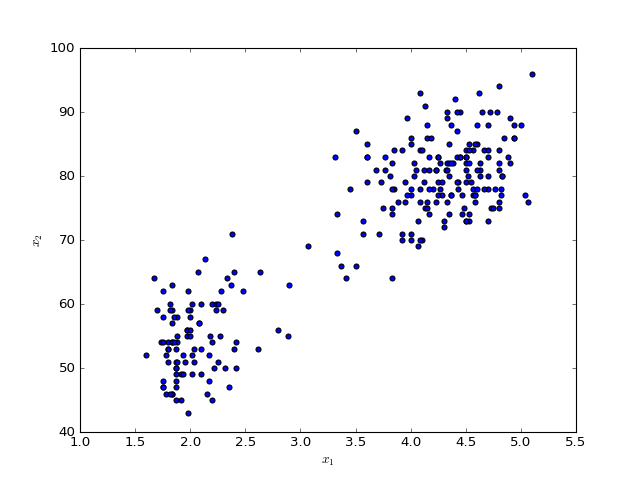

In [3]:
import pandas
df = pandas.read_csv(path, sep=' ', names=['x_1', 'x_2'])

x1 = df.loc[:,'x_1'].as_matrix()
x2 = df.loc[:,'x_2'].as_matrix()


figure()
scatter(x1, x2)
xlabel(r'$x_1$')
ylabel(r'$x_2$')
show()

Let's start with a marginal distribution

<IPython.core.display.Javascript object>


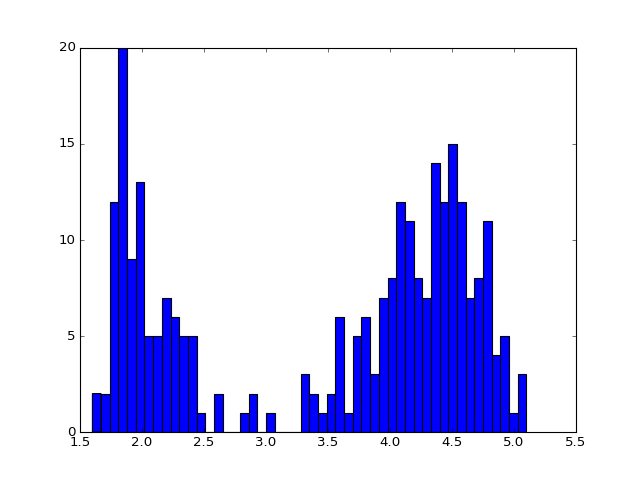

In [4]:
figure()
hist(x1, bins=50)
show()

This look's like maybe it is two Gaussians; let's focus on the one on the right. 

<IPython.core.display.Javascript object>


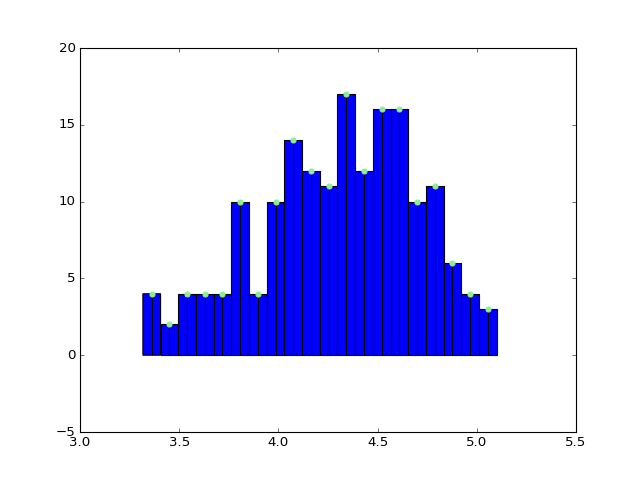

In [5]:
threshold = 3.25
x_r = x1[x1 > threshold]

figure()
hist(x_r, bins=20)
show()

In [6]:
freqs, edges = histogram(x_r, bins=20)
centers = (edges[:-1]+edges[1:])/2.

# This will be drawn on the figure above
vlines(centers, 0, freqs)
scatter(centers, freqs, color='lightgreen', zorder=2)
show()

# Challenge
Find the covariance an mean given `freqs` and `centers` only. 
Note that the input it not _samples_, it is a _sample value_ followed by a sample _wieight_

In [7]:
from scipy.stats import norm

In [8]:
def weighted_gaussian_fit(x, w):
    n = len(x)
    assert len(w) == n
    mu = 0
    var = 0
    for i in range(n):
        mu += w[i]*x[i]
        var += w[i]*x[i]**2
    total = sum(w)
    mu /= total
    var = var/total - mu**2
    
    return mu, var

The next cell lets you visualize the results. 

<IPython.core.display.Javascript object>


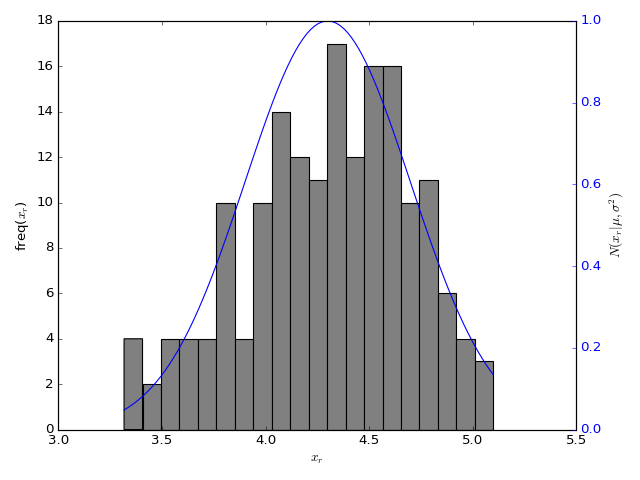

In [9]:
mu, var = weighted_gaussian_fit(centers, freqs)

x_fit = linspace(x_r.min(), x_r.max(), 100)
y_fit = (1./sqrt(2*pi*var))*exp(-((x_fit-mu)**2)/(2*var))

fig = figure()
hist(x_r, bins=20, color='grey', zorder=1)
xlabel(r'$x_r$')
ylabel(r'freq($x_r$)')

twinx()
ylabel('$N(x_r|\mu,\sigma^2)$')
tick_params('y', colors='blue')
plot(x_fit, y_fit, color='blue', zorder=2)
tight_layout()
show()

# Challenge
Now, let's extend that to a multivariate (2D) gaussian

In [10]:
x1_r = x_r
x2_r = x2[x1 > threshold ]

In [11]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


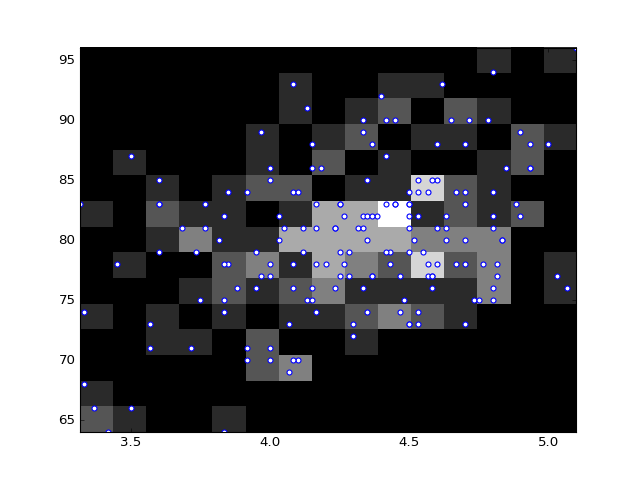

In [12]:
figure()
hist2d(x1_r, x2_r, bins=(15, 15), cmap=cm.gray)
scatter(x1_r, x2_r, edgecolor='blue', facecolor='white')
show()

In [13]:
freqs, x1_edges, x2_edges = histogram2d(x1_r, x2_r, bins=(15, 15))
x1_centers = (x1_edges[:-1] + x1_edges[1:])/2.
x2_centers = (x2_edges[:-1] + x2_edges[1:])/2.

In [14]:
x1_centers, x2_centers= meshgrid((x1_edges[:-1] + x1_edges[1:])/2., 
                                 (x2_edges[:-1] + x2_edges[1:])/2.)
x_centers = column_stack([x1_centers.flat, x2_centers.flat])
freqs = freqs.flatten()

Let's verify that we have coordinate pairs $(x_1, x_2)$ and frequencies aligned properly by visualizing the weighted points as circles of different sizes. 

Now, the challenge is to find the **2D** gaussian function that is most likely. 

In [15]:
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

In [16]:
def weighted_mv_guassian_fit(x, w):
    n = len(x)
    m = x.shape[1]
    mu = zeros(m)
    cov = zeros((m,m))
    for i in range(n):
        mu += w[i]*x[i]
        cov += w[i]*outer(x[i], x[i])
    mu /= sum(w)
    cov = cov/sum(w) - outer(mu, mu)
    return mu, cov

<IPython.core.display.Javascript object>


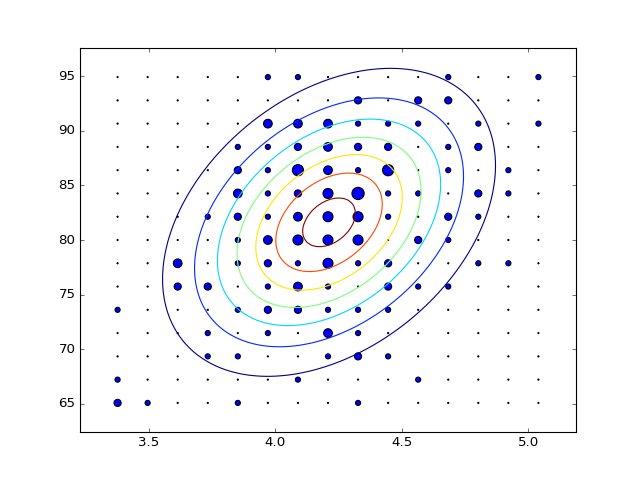

In [17]:
figure()
scatter(x_centers[:,0], x_centers[:,1], s=1+20*freqs)
mu, cov = weighted_mv_guassian_fit(x_centers, freqs)
x1_fit, x2_fit = mgrid[x1_r.min():x1_r.max():100j, x2_r.min():x2_r.max():100j]
z_fit = zeros_like(x1_fit)
for i in range(100):
    for j in range(100):
        z_fit[i,j] = multivariate_normal.pdf(array([x1_fit[i,j], x2_fit[i,j]]).T,
                                             mean=mu,
                                             cov=cov)
show()
contour(x1_fit, x2_fit, z_fit)

# Challenges multiple 1D Gaussians
Returning to the original data, we thought that $x_1$  may have been a mixture of two gaussians.

Later, we may discuss Gaussian mixture models in more depth (PRML Ch. 9). 

For now, I will introduce a simple _K means_ algorithm, with pseudocode:

<img src="http://stanford.edu/~cpiech/cs221/img/kmeansMath.png"></img>

This algorithm solves _only_ for the means of a set of Gaussian's, and it assumes that they all have the same variance. 

In [18]:
from scipy.spatial.distance import cdist

In [19]:
def kmeans(x, k):
    # This algorithm iteratively reduces the negative log likelihood
    # It stops when two iterations result in the same cluster assignments 
    converged = False
    
    # Select `k` initial 'mus', e.g. using np.random.choice?
    mus = x[random.choice(len(x), k)]
    
    while not converged:
        if len(x.shape) ==2:
            dist = column_stack([ np.linalg.norm(x-mu, axis=1)**2 for mu in mus ])
        else:
            dist = column_stack([ (x-mu)**2 for mu in mus ])
        
        clusters = argmin(dist, axis=1)
        
        old_mus = mus
        mus = array([mean(x[clusters==i], axis=0) for i in range(k)])
        
        converged = all(mus == old_mus)
        
        yield old_mus, clusters

In [20]:
process = kmeans(x1, 2)

<IPython.core.display.Javascript object>


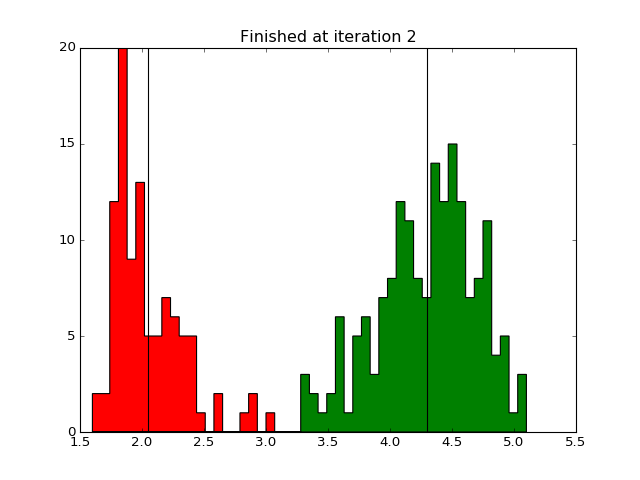

In [31]:
# The plot will look incorrect until you fix the code above
fig = figure()
from time import sleep
for k, (mus, clusters) in enumerate(kmeans(x1, 2)):
    clf()
    x1_range = (x1.min(), x1.max())
    hist(x1[clusters==0], bins=50, range=x1_range, histtype='stepfilled', color='red')
    hist(x1[clusters==1], bins=50, range=x1_range, histtype='stepfilled', color='green')
    vlines(mus, 0, ylim()[1])
    title('Iteration {}'.format(k))
    fig.canvas.draw()
    savefig('kmeans-1d-frame-{:04}.jpg'.format(k))
    sleep(2)
title('Finished at iteration {}'.format(k))

In [32]:
ls

bezdekIris.data   kmeans-1d-frame-0000.jpg   lab-02-solution.ipynb
ch02-notes.ipynb  kmeans-1d-frame-0001.jpg   Lab 03.ipynb
faithful.txt      kmeans-1d-frame-0002.jpg   Lab 2.ipynb
Homework 2.ipynb  kmeans-1d-frame-{:04}.jpg  prmlfigs/


In [34]:
!ffmpeg -i kmeans-1d-frame-%04d.jpg  kmeans-1d.mp4
from IPython.display import Video

ffmpeg version 3.2.2 Copyright (c) 2000-2016 the FFmpeg developers
  built with gcc 4.8 (Ubuntu 4.8.4-2ubuntu1~14.04.3)
  configuration: --extra-libs=-ldl --prefix=/opt/ffmpeg --mandir=/usr/share/man --enable-avresample --disable-debug --enable-nonfree --enable-gpl --enable-version3 --enable-libopencore-amrnb --enable-libopencore-amrwb --disable-decoder=amrnb --disable-decoder=amrwb --enable-libpulse --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libx265 --enable-libfdk-aac --enable-libvorbis --enable-libmp3lame --enable-libopus --enable-libvpx --enable-libspeex --enable-libass --enable-avisynth --enable-libsoxr --enable-libxvid --enable-libvidstab --enable-libwavpack --enable-nvenc
  libavutil      55. 34.100 / 55. 34.100
  libavcodec     57. 64.101 / 57. 64.101
  libavformat    57. 56.100 / 57. 56.100
  libavdevice    57.  1.100 / 57.  1.100
  libavfilter     6. 65.100 /  6. 65.100
  libavresample   3.  1.  0 /  3.  1.  0
  libswscale      4.  2.100 /  4.  2.100
  lib

ImportError: cannot import name Video

# More of the Same Challenge...
If you implemented the code above _just_ right (or if you edit it a bit), then it will work on multidimensional data as well. 
Give it a try:

In [22]:
X = column_stack([x1, x2])

<IPython.core.display.Javascript object>


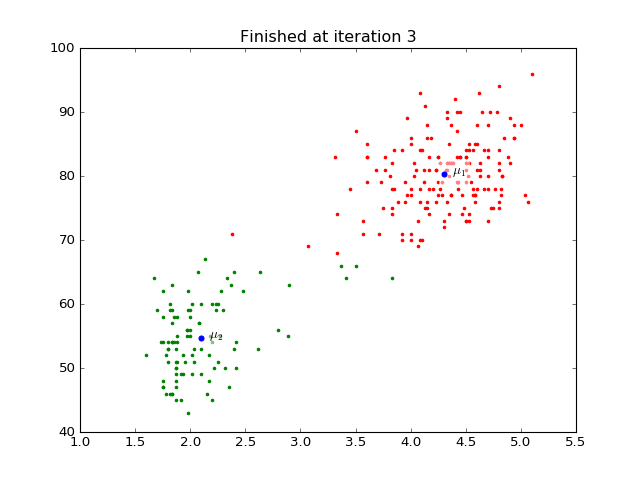

In [23]:
fig = figure()

for k, (mus, clusters) in enumerate(kmeans(X, 2)):
    clf()
    scatter(x1[clusters==0], x2[clusters==0], color='red', s=5)
    scatter(x1[clusters==1], x2[clusters==1], color='green', s=5)
    scatter(mus[:,0], mus[:,1], color='blue', zorder=3)
    text(mus[0,0], mus[0,1], '  $\mu_1$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
    text(mus[1,0], mus[1,1], '  $\mu_2$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
    title('Iteration {}'.format(k))
    fig.canvas.draw()
    sleep(2)
title('Finished at iteration {}'.format(k))
    